# Unsupervised Learning Capstone #

## ArXiv Topic Clustering ##

#### Overview ####

ArXiv is a repository consisting of over 1.5 million scientific papers in fields such as mathematics, computer science, and physics. It is owned and operated by Cornell University.

This capstone will explore the use of different clustering methods to predict the topic of each paper. I will be attempting to use K-Means, DBSCAN (Density-based Spatial Clustering of Applications with Noise), and the Gaussian Mixture Model.

In [9]:
import pandas as pd
import numpy as np
import arxiv
import spacy
import re
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_md")

In [10]:
result = arxiv.query("all",max_results=100000)

df = pd.DataFrame(result)

There are many different topics discussed in the arXiv scientific papers. I will be focusing solely on mathematics, computer science, and physics. As such I have imported 100,000 papers so I will be able to grab only 1000 of each topic.

In [11]:
df.head()

,affiliation,arxiv_comment,arxiv_primary_category,arxiv_url,author,author_detail,authors,doi,guidislink,id,...,pdf_url,published,published_parsed,summary,summary_detail,tags,title,title_detail,updated,updated_parsed
0,None,None,"{'term': 'math.NA', 'scheme': 'http://arxiv.or...",http://arxiv.org/abs/1210.7708v1,Alexei Shadrin,{'name': 'Alexei Shadrin'},[Alexei Shadrin],None,True,http://arxiv.org/abs/1210.7708v1,...,http://arxiv.org/pdf/1210.7708v1,2012-10-29T16:12:41Z,"(2012, 10, 29, 16, 12, 41, 0, 303, 0)",The Landau-Kolmogorov problem consists of find...,"{'type': 'text/plain', 'language': None, 'base...","[{'term': 'math.NA', 'scheme': 'http://arxiv.o...",Landau--Kolmogorov inequality revisited,"{'type': 'text/plain', 'language': None, 'base...",2012-10-29T16:12:41Z,"(2012, 10, 29, 16, 12, 41, 0, 303, 0)"
1,None,"23 pages, 7 figures","{'term': 'cond-mat.mtrl-sci', 'scheme': 'http:...",http://arxiv.org/abs/1602.00450v1,M. Kawasaki,{'name': 'M. Kawasaki'},"[T. C. Fujita, M. Uchida, Y. Kozuka, W. Sano, ...",10.1103/PhysRevB.93.064419,True,http://arxiv.org/abs/1602.00450v1,...,http://arxiv.org/pdf/1602.00450v1,2016-02-01T09:53:30Z,"(2016, 2, 1, 9, 53, 30, 0, 32, 0)","Pyrochlore oxides possessing ""all-in-all-out"" ...","{'type': 'text/plain', 'language': None, 'base...","[{'term': 'cond-mat.mtrl-sci', 'scheme': 'http...",All-in-all-out magnetic domain wall conduction...,"{'type': 'text/plain', 'language': None, 'base...",2016-02-01T09:53:30Z,"(2016, 2, 1, 9, 53, 30, 0, 32, 0)"
2,None,None,"{'term': 'cs.DC', 'scheme': 'http://arxiv.org/...",http://arxiv.org/abs/1612.01842v2,Zaid Hussain,{'name': 'Zaid Hussain'},[Zaid Hussain],None,True,http://arxiv.org/abs/1612.01842v2,...,http://arxiv.org/pdf/1612.01842v2,2016-12-06T15:01:47Z,"(2016, 12, 6, 15, 1, 47, 1, 341, 0)","Recently, a higher dimensional Eisenstein-Jaco...","{'type': 'text/plain', 'language': None, 'base...","[{'term': 'cs.DC', 'scheme': 'http://arxiv.org...",An Improved One-to-All Broadcasting in Higher ...,"{'type': 'text/plain', 'language': None, 'base...",2016-12-07T06:10:53Z,"(2016, 12, 7, 6, 10, 53, 2, 342, 0)"
3,None,"33 pages, 18 figures","{'term': 'math.CO', 'scheme': 'http://arxiv.or...",http://arxiv.org/abs/0705.3599v1,Chris Smyth,{'name': 'Chris Smyth'},"[James McKee, Chris Smyth]",None,True,http://arxiv.org/abs/0705.3599v1,...,http://arxiv.org/pdf/0705.3599v1,2007-05-24T15:45:39Z,"(2007, 5, 24, 15, 45, 39, 3, 144, 0)",We completely describe all integer symmetric m...,"{'type': 'text/plain', 'language': None, 'base...","[{'term': 'math.CO', 'scheme': 'http://arxiv.o...",Integer symmetric matrices having all their ei...,"{'type': 'text/plain', 'language': None, 'base...",2007-05-24T15:45:39Z,"(2007, 5, 24, 15, 45, 39, 3, 144, 0)"
4,None,"10 pages, Journal ""Algebra and Discrete Mathem...","{'term': 'math.RA', 'scheme': 'http://arxiv.or...",http://arxiv.org/abs/0811.3325v1,Slavcho Shtrakov,{'name': 'Slavcho Shtrakov'},"[Jorg Koppitz, Slavcho Shtrakov]",None,True,http://arxiv.org/abs/0811.3325v1,...,http://arxiv.org/pdf/0811.3325v1,2008-11-20T12:28:46Z,"(2008, 11, 20, 12, 28, 46, 3, 325, 0)",The extensions of hypersubstitutions are mappi...,"{'type': 'text/plain', 'language': None, 'base...","[{'term': 'math.RA', 'scheme': 'http://arxiv.o...",On mappings of terms determined by hypersubsti...,"{'type': 'text/plain', 'language': None, 'base...",2008-11-20T12:28:46Z,"(2008, 11, 20, 12, 28, 46, 3, 325, 0)"


In [12]:
df.columns

Index(['affiliation', 'arxiv_comment', 'arxiv_primary_category', 'arxiv_url',
       'author', 'author_detail', 'authors', 'doi', 'guidislink', 'id',
       'journal_reference', 'links', 'pdf_url', 'published',
       'published_parsed', 'summary', 'summary_detail', 'tags', 'title',
       'title_detail', 'updated', 'updated_parsed'],
      dtype='object')

As seen above, there are many features in this dataset. To predict the topic, I will only be using the text in the summary and title. All of the other features will not be beneficial to the clustering models. Below, I have added a feature "text" that is the concatenation of the summary and title. And I have dropped all of the other features.

In [13]:
df['text'] = df['summary'] + " " + df['title']
df = df.drop(columns=['affiliation','arxiv_comment','arxiv_url',
                     'author_detail','doi','guidislink','id',
                     'pdf_url','links','published','summary_detail',
                     'title_detail','updated','updated_parsed',
                     'journal_reference','tags','author','authors',
                     'published_parsed','summary','title'])

In [14]:
df.head()

,arxiv_primary_category,text
0,"{'term': 'math.NA', 'scheme': 'http://arxiv.or...",The Landau-Kolmogorov problem consists of find...
1,"{'term': 'cond-mat.mtrl-sci', 'scheme': 'http:...","Pyrochlore oxides possessing ""all-in-all-out"" ..."
2,"{'term': 'cs.DC', 'scheme': 'http://arxiv.org/...","Recently, a higher dimensional Eisenstein-Jaco..."
3,"{'term': 'math.CO', 'scheme': 'http://arxiv.or...",We completely describe all integer symmetric m...
4,"{'term': 'math.RA', 'scheme': 'http://arxiv.or...",The extensions of hypersubstitutions are mappi...


I will be utilizing the "arxiv_primary_category" feature as my outcome variable. However the dataset's version of the feature is too complex. Below, I strip down each primary category.

In [15]:
df['arxiv_primary_category'] = df['arxiv_primary_category'].astype(str).str.replace('{\'term\': \'','').str.replace(r'\.(.*)','').str.replace(r'\',(.*)','')

In [16]:
df['arxiv_primary_category'].unique()

array(['math', 'cond-mat', 'cs', 'astro-ph', 'hep-th', 'physics',
       'quant-ph', 'dg-ga', 'hep-ph', 'hep-lat', 'math-ph', 'stat',
       'q-bio', 'q-alg', 'gr-qc', 'alg-geom', 'q-fin', 'hep-ex', 'nlin',
       'nucl-th', 'econ', 'nucl-ex', 'acc-phys', 'chao-dyn', 'chem-ph',
       'cmp-lg', 'funct-an', 'mtrl-th', 'solv-int', 'eess', 'adap-org',
       'comp-gas', 'patt-sol'], dtype=object)

With the categories stripped down there are much fewer unique outcomes.

In [18]:
df['arxiv_primary_category'].value_counts()

math        5789
cs           995
hep-th       730
cond-mat     557
quant-ph     510
astro-ph     476
hep-ph       472
physics      445
gr-qc        243
math-ph      222
hep-lat       98
nlin          90
q-bio         79
nucl-th       67
stat          58
hep-ex        39
q-fin         25
alg-geom      25
q-alg         20
chao-dyn      11
dg-ga         10
solv-int      10
nucl-ex        7
eess           6
econ           4
funct-an       4
cmp-lg         2
acc-phys       1
adap-org       1
mtrl-th        1
comp-gas       1
chem-ph        1
patt-sol       1
Name: arxiv_primary_category, dtype: int64

Here I am looking at the value counts so I can resample the topics I will be focusing on. Of the 100,000 papers I pulled, 5789 are mathematics, 995 are computer science, and 445 are physics. I will need to downsample the mathematics and upsample the computer science and physics.

In [19]:
df_math = df.loc[df['arxiv_primary_category'] == 'math']
df_cs = df.loc[df['arxiv_primary_category'] == 'cs']
df_physics = df.loc[df['arxiv_primary_category'] == 'physics']

In [20]:
from sklearn.utils import resample

df_math = resample(df_math, replace=False, n_samples=1000, random_state=123)
df_cs = resample(df_cs, replace=True, n_samples=1000, random_state=123)
df_physics = resample(df_physics, replace=True, n_samples=1000, random_state=123)

df2 = pd.concat([df_math, df_cs, df_physics])

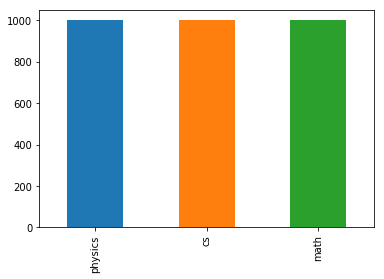

In [62]:
ax = df2['arxiv_primary_category'].value_counts().plot(kind='bar')

Now my new dataframe only consists of 1000 papers of each mathematics, computer science, and physics.

In [23]:
tokens = []
lemma = []
pos = []

for doc in nlp.pipe(df2['text'].astype('unicode').values, batch_size=50,
                        n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc])
        lemma.append([n.lemma_ for n in doc])
        pos.append([n.pos_ for n in doc])
    else:
        tokens.append(None)
        lemma.append(None)
        pos.append(None)

df2['tokens'] = tokens
df2['lemma'] = lemma
df2['pos'] = pos

Here I am tokenizing and parsing the text in the "text" feature. This is adding 3 new columns of the tokens, lemmas, and parts of speech for each title and summary. As well as another feature "text_parsed" which contains the word vectors.

In [24]:
df2['text_parsed'] = df2['text'].apply(lambda x: nlp(x).vector)

In [25]:
df2.isnull().sum()

arxiv_primary_category    0
text                      0
tokens                    0
lemma                     0
pos                       0
text_parsed               0
dtype: int64

There are no null values.

In [18]:
df2.dtypes

arxiv_primary_category    object
text                      object
tokens                    object
lemma                     object
pos                       object
text_parsed               object
dtype: object

All of the features as well as the outcome variable are object types.

In [26]:
X = df2['text_parsed']
y = df2.arxiv_primary_category

I am assigning the parsed text feature to X and the primary category (the outcome variable) to y.

In [27]:
X_arrays = np.vstack(X.values)

This is concatenating the word vectors into single arrays.

In [28]:
from sklearn.preprocessing import normalize
X_norm = normalize(X_arrays)

Next I normalized the X for the clustering models.

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, random_state=111)

I split my training and test sets as 75% and 25% respectively.

In [31]:
X_norm.shape

(3000, 300)

In [30]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(100)
svd.fit(X_train)

print(svd.explained_variance_ratio_)  
print(svd.explained_variance_ratio_.sum())

[0.00894463 0.18430158 0.10662436 0.07868079 0.04182838 0.03623129
 0.02880336 0.02655186 0.02254033 0.0201946  0.01558373 0.01521377
 0.01306235 0.01222345 0.01177035 0.01114411 0.00978005 0.00906268
 0.00895969 0.00823114 0.00815126 0.00767209 0.00753836 0.00669841
 0.00656575 0.00618652 0.00598505 0.00573699 0.00561091 0.00536741
 0.00530023 0.00524479 0.00504084 0.00469268 0.00457017 0.00448889
 0.00426207 0.00414235 0.00400096 0.00389312 0.00378171 0.00358737
 0.003511   0.0034757  0.00339261 0.0033213  0.00322833 0.00321523
 0.00312133 0.00299679 0.00295486 0.00289883 0.00283078 0.00275963
 0.00271429 0.00263062 0.00255553 0.00250252 0.00249135 0.00242717
 0.00239282 0.00233184 0.00228017 0.00225966 0.00214315 0.00212435
 0.00211428 0.00205887 0.00202624 0.00199163 0.00198113 0.00192912
 0.00189948 0.00181121 0.00178033 0.00176518 0.00176224 0.00172578
 0.00171943 0.00165752 0.00162104 0.00161005 0.00159848 0.00156132
 0.00155576 0.00153207 0.00152479 0.00149699 0.00148246 0.0014

X originally had 3,000 features. I used Truncated SVD to reduce X down to 100 components which explains approximately 90% of the variance.

As previously stated, this dataset will be used on 3 different types of clustering methods which are also of 3 different levels (hard to soft).

## K-Means Clustering ##

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score

km = KMeans(n_clusters=3, random_state=42)
km.fit(X_train)
y_pred = km.predict(X_train)

First I try k-means clustering which is a type of hard clustering. With k-means, I define the number of clusters or centroids which is 3 for the number of topics I am focusing on. This model defaults to 10 times that the algorithm runs with different centroids and 300 iterations on a single run.

In [33]:
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train, y_pred))

print("\nHomogeneity score: %0.3f" % homogeneity_score(y_train, km.labels_))

Comparing k-means clusters against the data:
col_0                     0    1    2
arxiv_primary_category               
cs                      115   17  608
math                    257    5  485
physics                  15  451  297

Homogeneity score: 0.245


As seen above, this model does not do a great job of clustering the dataset for each topic. Cluster 0 has a majority of math papers, however there are also a number of computer science papers as well. Cluster 1 seems to be very physics focused (as seen later this is pretty consistent across all three models). Cluster 2 has a large number of each topic. The homogeneity score is very low with a 24.5% accuracy. The drawback for this clustering model in terms of the dataset is the assumption that the clusters are radially symmetrical and have similar variances.

## DBSCAN (Density-based Spatial Clustering of Applications with Noise) ##

In [91]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps=0.35, min_samples=3)
dbs.fit(X_train)
y_pred = dbs.fit_predict(X_train)

n_clusters_ = len(set(dbs.labels_)) - (1 if -1 in dbs.labels_ else 0)
n_noise_ = list(dbs.labels_).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 55


Next I try DBSCAN clustering which is still a type of hard clustering however unlike k-means the clusters can take arbitrary shapes. Also unlike k-means, I am unable to define the number of clusters. I tried a number of different combination of parameters in regards to the epsilon (maximum distance) and number of minimum points.

* Low epsilon, high number of minimum points - results in 0 clusters and all datapoints become noise
* Low epsilon, low number of minimum points - large number of clusters but vast majority of datapoints become noise
* High epsilon, low number of minimum points - results in 1 cluster and no noise
* High epsilon, high number of minimum points - results in 1 cluster and no noise

After testing a few different combinations, an epsilon of 0.35 and a number of minimum points of 3 resulted in 4 clusters and minimal noise.

In [92]:
print('Comparing DBSCAN clusters against the data:')
print(pd.crosstab(y_train, y_pred))

print("\nHomogeneity score: %0.3f" % homogeneity_score(y_train, dbs.labels_))

Comparing DBSCAN clusters against the data:
col_0                   -1    0   1   2   3
arxiv_primary_category                     
cs                       6  731   0   3   0
math                    38  709   0   0   0
physics                 11  745   4   0   3

Homogeneity score: 0.011


As seen above, this model also did not do a great job of clustering based on the different topics. Even though I was able to create more clusters after tuning the parameters, most of the datapoints ended up in cluster 0. Similarly to k-means, physics had the most datapoints that were assigned to clusters outside of cluster 0. The homogeneity score is extremely low with a 1.1% accuracy. As this model relies on density, that suggests the dataset as a whole is very dense and thus the parameters are extremely sensitive either causing the datapoints to become one cluster or all noise. The drawbacks on this model are its sensitivity to the parameters and it struggles with high dimensionality.

## Gaussian Mixture Model (GMM) Clustering ##

In [102]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3)
gm.fit(X_train)
y_pred = gm.predict(X_train)

Lastly I try the Gaussian Mixture Model clustering which is a type of soft clustering. This type of clustering is very similar to k-means however, unlike k-means, it takes variance into consideration. The "weighted" distances may help with defining the clusters better. With this model, I was able to define the number of clusters to be 3 so the model knew to fit 3 Gaussians. The maximum number of EM iterations is defaulted to 100, however as we will see later the model hits the default convergence threshold of 1e-3 and ends after only 2 EM iterations.

In [103]:
print('Comparing gaussian mixture clusters against the data:')
print(pd.crosstab(y_train, y_pred))

Comparing gaussian mixture clusters against the data:
col_0                     0    1    2
arxiv_primary_category               
cs                       16  604  120
math                      5  480  262
physics                 449  299   15


In [104]:
gm.weights_

array([0.20888889, 0.61466667, 0.17644444])

In [107]:
print("The number of EM iterations: %0.0f" % gm.n_iter_)

The number of EM iterations: 2


In [97]:
# Compute the per-sample average log-likelihood of the given data X.
gm.score(X_train, y_train)

1093.7191838719593

The clusters created by this model are practically the same as the k-means clusters. Once again, physics is mainly focused in cluster 0 but there are a large number of each topic in cluster 1 and a large number of math and computer science in cluster 2. It appears that the variance did not help the clusters become more defined by each topic.

### Conclusion ###

In conclusion, the dataset appears to be quite dense and has difficulty clustering. The physics papers seem to be better at clustering from the math and computer science papers. I may be able to help diverge the different topics by using more word importance. Currently, physics may have more unique words than math and computer science.

### Next Steps ###

* Topic Modeling Classifiers
* Word Importance